In [60]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


In [44]:
data = pd.read_csv("data/green_monkey/all_structure_files/chr1/chr1_expr_acc_features.csv")
data.head()

,gene_name,log2FC_12h,log2FC_18h,log2FC_24h,acc_untr_12h_tss,acc_untr_12h_avg,acc_vacv_12h_tss,acc_vacv_12h_avg,acc_untr_18h_tss,acc_untr_18h_avg,...,acc_delta_24h_avg,expr_var,expr_range,acc_tss_var,acc_tss_range,acc_avg_var,acc_avg_range,expr_slope,acc_tss_slope,acc_avg_slope
0,SCGB1C1,NaN,NaN,NaN,5.77405,8.179925,12.13380,6.516307,3.02076,5.092134,...,NaN,NaN,NaN,7.752544,3.93765,2.614005,2.286484,NaN,-0.656275,0.381081
1,ODF3,NaN,NaN,NaN,5.77405,4.210245,5.39281,4.718710,3.92698,4.805749,...,0.497375,NaN,NaN,1.642106,2.44088,0.030279,0.306784,NaN,-0.045313,-0.000924
2,BET1L,-0.315039,-0.368512,-0.155558,18.76570,23.817953,6.06692,16.777641,3.32283,13.126565,...,-1.231253,0.012274,0.212954,116.095373,20.95888,9.633200,5.809059,0.013290,1.746573,0.484088
3,RIC8A,-0.295795,-0.221668,-0.362167,18.76570,19.728002,4.04461,16.552940,4.22906,15.305173,...,-12.221523,0.004940,0.140500,150.137489,24.09109,26.300381,9.046461,-0.005531,-0.679683,-0.753872
4,SIRT3,0.552196,-0.984313,0.300940,3.84937,15.466200,4.71871,12.673082,3.62491,9.389523,...,-6.898180,0.679310,1.536509,0.986908,1.96658,5.193753,4.105062,-0.020938,-0.163882,-0.342088


In [45]:
# Define the timepoint columns for expression and accessibility
expr_cols = ['expr_delta_12h', 'expr_delta_18h', 'expr_delta_24h']
acc_tss_cols = ['acc_delta_12h_tss', 'acc_delta_18h_tss', 'acc_delta_24h_tss']
acc_avg_cols = ['acc_delta_12h_avg', 'acc_delta_18h_avg', 'acc_delta_24h_avg']

diffs = []
for colset in [expr_cols, acc_tss_cols, acc_avg_cols]:
    diffs += list((data[colset[1]] - data[colset[0]]).abs())
    diffs += list((data[colset[2]] - data[colset[1]]).abs())
diffs = [d for d in diffs if not np.isnan(d)]
thres = np.percentile(diffs, 33)  # or 25, or 50 (median)


# Function to get directional code between adjacent timepoints
# > thr up, < thr down else neutral
def direction_sequence(values, threshold=0.05):
    dirs = []
    for i in range(1, len(values)):
        diff = values[i] - values[i-1]
        if np.isnan(diff):
            dirs.append('NA')
        elif diff > threshold:
            dirs.append('↑')
        elif diff < -threshold:
            dirs.append('↓')
        else:
            dirs.append('→')
    return dirs


In [46]:
# Apply to all genes
data['expr_dir'] = data[expr_cols].apply(
    lambda row: direction_sequence(row.values, threshold=thres), axis=1)
data['acc_tss_dir'] = data[acc_tss_cols].apply(
    lambda row: direction_sequence(row.values, threshold=thres), axis=1)
# data['acc_avg_dir'] = data[acc_avg_cols].apply(
#     lambda row: direction_sequence(row.values), axis=1)

# Example output per gene: ['↑', '↓']


In [49]:
# Define updated 9-category mapping
pair_to_category = {
    '↑/↑': 'increase',
    '↓/↓': 'decrease',
    '→/→': 'neutral',
    '↑/↓': 'expr_up_acc_down',
    '↓/↑': 'expr_down_acc_up',
    '↑/→': 'expr_only_up',
    '↓/→': 'expr_only_down',
    '→/↑': 'acc_only_up',
    '→/↓': 'acc_only_down'
}

# Updated agreement pattern function that returns both categories and direction pairs
def agreement_pattern(seq1, seq2):
    agreement = []
    direction_pairs = []
    for a, b in zip(seq1, seq2):
        if 'NA' in (a, b):
            agreement.append('NA')
            direction_pairs.append(['NA', 'NA'])
        else:
            agreement.append(pair_to_category.get(f'{a}/{b}', 'NA'))
            direction_pairs.append([a, b])
    return agreement, direction_pairs

# Apply to each gene and unpack result
results = data.apply(lambda row: agreement_pattern(row['expr_dir'], row['acc_tss_dir']), axis=1)
data[['expr_acc_tss_agreement', 'expr_acc_direction_pairs']] = pd.DataFrame(results.tolist(), index=data.index)

# Combine into readable form
def combine_pairs_and_labels(pairs, labels):
    return [f"{a}/{b} → {label}" for (a, b), label in zip(pairs, labels)]

# Format direction pairs as strings without result labels
data['expr_acc_direction_pairs_str'] = data['expr_acc_direction_pairs'].apply(
    lambda pairs: [f"{a}/{b}" for a, b in pairs]
)


data[['gene_name', 'expr_dir', 'acc_tss_dir', 'expr_acc_direction_pairs', 'expr_acc_tss_agreement']].head()


,gene_name,expr_dir,acc_tss_dir,expr_acc_direction_pairs,expr_acc_tss_agreement
0,SCGB1C1,"[NA, NA]","[↓, NA]","[[NA, NA], [NA, NA]]","[NA, NA]"
1,ODF3,"[NA, NA]","[↑, ↓]","[[NA, NA], [NA, NA]]","[NA, NA]"
2,BET1L,"[→, →]","[↑, ↑]","[[→, ↑], [→, ↑]]","[acc_only_up, acc_only_up]"
3,RIC8A,"[→, →]","[↑, ↓]","[[→, ↑], [→, ↓]]","[acc_only_up, acc_only_down]"
4,SIRT3,"[↓, ↑]","[↓, ↓]","[[↓, ↓], [↑, ↓]]","[decrease, expr_up_acc_down]"


In [50]:
def agreement_summary_new(agreement_seq):
    return pd.Series({
        'increase': agreement_seq.count('increase'),
        'decrease': agreement_seq.count('decrease'),
        'neutral': agreement_seq.count('neutral'),
        'expr_only_up': agreement_seq.count('expr_only_up'),
        'expr_only_down': agreement_seq.count('expr_only_down'),
        'acc_only_up': agreement_seq.count('acc_only_up'),
        'acc_only_down': agreement_seq.count('acc_only_down'),
        'expr_up_acc_down': agreement_seq.count('expr_up_acc_down'),
        'expr_down_acc_up': agreement_seq.count('expr_down_acc_up')
    })

# Apply it
data[['increase', 'decrease', 'neutral', 'expr_only_up', 'expr_only_down',
      'acc_only_up', 'acc_only_down', 'expr_up_acc_down', 'expr_down_acc_up']] = (
    data['expr_acc_tss_agreement'].apply(agreement_summary_new)
)

# Flatten the list of agreement types across all genes
all_agreement_labels = sum(data['expr_acc_tss_agreement'].tolist(), [])

# Get value counts as a DataFrame
value_counts_df = pd.Series(all_agreement_labels).value_counts().reset_index()
value_counts_df.columns = ['agreement_type', 'count']

# View result
print(value_counts_df)


     agreement_type  count
0                NA    959
1     acc_only_down    530
2       acc_only_up    454
3           neutral    162
4          decrease    150
5  expr_up_acc_down    117
6  expr_down_acc_up    100
7          increase     87
8      expr_only_up     48
9    expr_only_down     39


In [56]:
def classify_agreement(row):
    # Extract and convert to numeric (in case of bad data)
    counts = pd.to_numeric(row[
        ['increase', 'decrease', 'neutral',
         'expr_only_up', 'expr_only_down',
         'acc_only_up', 'acc_only_down',
         'expr_up_acc_down', 'expr_down_acc_up']
    ], errors='coerce').fillna(0).astype(int)
    
    max_type = counts.idxmax()
    max_count = counts.max()
    
    # Coordinated trends
    if max_type == 'increase' and max_count == 2:
        return 'expr_acc_up'
    elif max_type == 'decrease' and max_count == 2:
        return 'expr_acc_down'
    
    # Strong conflict
    elif (counts['expr_up_acc_down'] + counts['expr_down_acc_up']) == 2:
        return 'conflict'
    
    # One-sided regulation
    elif 'expr_only' in max_type:
        return 'expression_only'
    elif 'acc_only' in max_type:
        return 'accessibility_only'
    
    # Stable
    elif max_type == 'neutral':
        return 'stable'
    
    return 'mixed'

data['agreement_class'] = data.apply(classify_agreement, axis=1)


In [57]:
data['agreement_class'].value_counts()


agreement_class
mixed                 663
accessibility_only    444
stable                133
expression_only        54
conflict               24
expr_acc_down           5
Name: count, dtype: int64

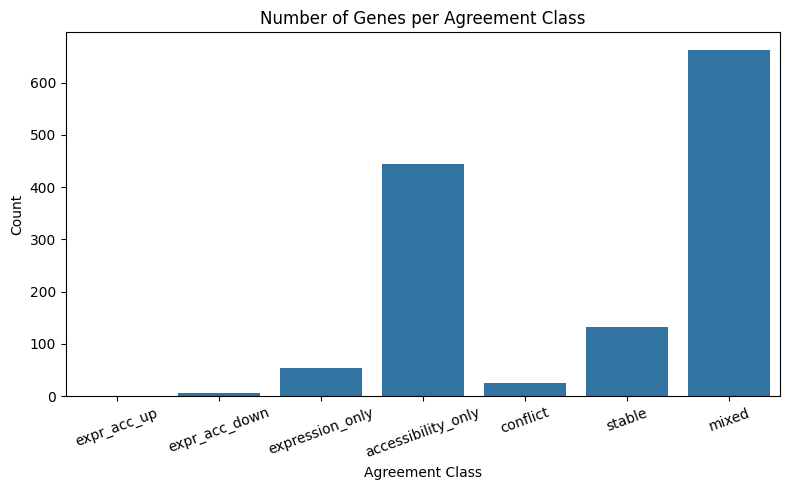

In [58]:
plt.figure(figsize=(8, 5))
sns.countplot(
    x='agreement_class',
    data=data,
    order=[
        'expr_acc_up', 'expr_acc_down',
        'expression_only', 'accessibility_only',
        'conflict', 'stable', 'mixed'
    ]
)
plt.title("Number of Genes per Agreement Class")
plt.ylabel("Count")
plt.xlabel("Agreement Class")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

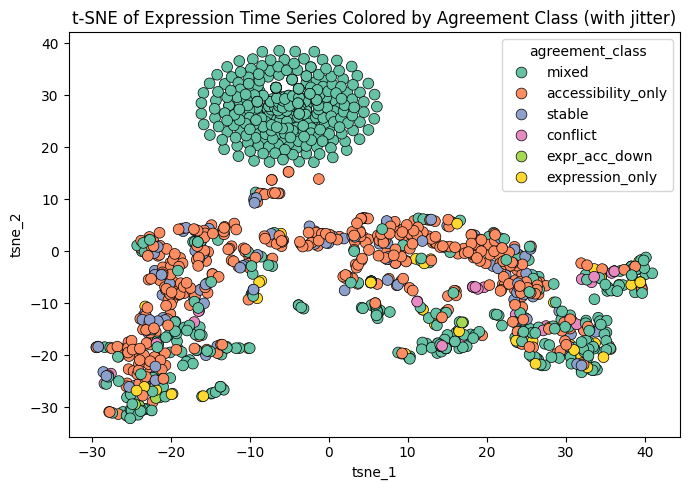

In [63]:
# Create feature matrix from expression time series
X = data[['expr_delta_12h', 'expr_delta_18h', 'expr_delta_24h']].fillna(0).values

# Run t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(X)

# Store raw t-SNE coordinates
data['tsne_1'] = X_embedded[:, 0]
data['tsne_2'] = X_embedded[:, 1]

# # Add jitter to reduce overplotting
# data['tsne_1_jitter'] = data['tsne_1'] + np.random.normal(0, 30.0, size=data.shape[0])
# data['tsne_2_jitter'] = data['tsne_2'] + np.random.normal(0, 30.0, size=data.shape[0])

# Plot
plt.figure(figsize=(7, 5))
sns.scatterplot(
    data=data,
    x='tsne_1',
    y='tsne_2',
    hue='agreement_class',
    palette='Set2',
    s=60,
    edgecolor='black',
    linewidth=0.5
)
plt.title("t-SNE of Expression Time Series Colored by Agreement Class (with jitter)")
plt.tight_layout()
plt.show()


Kept 802 of 1323 genes


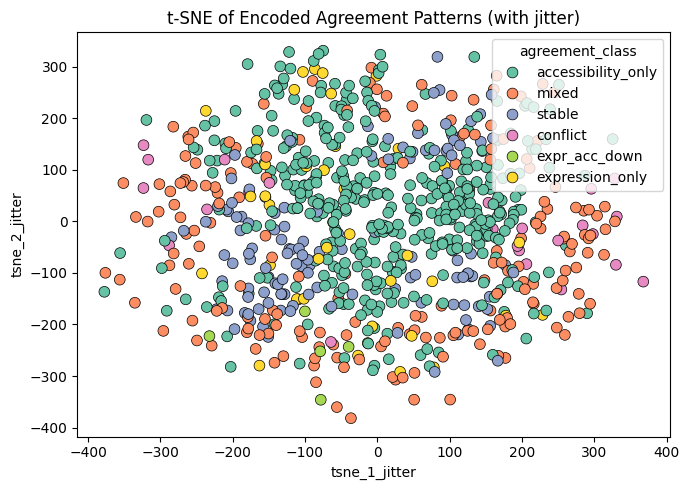

In [66]:
# Define updated mapping for your new categories
agreement_map = {
    'increase': 2,
    'decrease': -2,
    'neutral': 0,
    'expr_only_up': 1,
    'expr_only_down': -1,
    'acc_only_up': 1,
    'acc_only_down': -1,
    'expr_up_acc_down': -2,
    'expr_down_acc_up': 2,
    'NA': np.nan
}

# Encode agreement values
agreement_encoded = data['expr_acc_tss_agreement'].apply(
    lambda seq: [agreement_map.get(s, np.nan) for s in seq]
).apply(pd.Series)

# Name columns (for t1 and t2)
agreement_encoded.columns = ['agree_t1', 'agree_t2']

# Drop rows with NA
agreement_clean = agreement_encoded.dropna()
print(f"Kept {len(agreement_clean)} of {len(agreement_encoded)} genes")

# Link metadata
meta = data.loc[agreement_clean.index, ['gene_name', 'agreement_class']]

# Run t-SNE
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
embedding = tsne.fit_transform(agreement_clean.values)

# Add coordinates
meta['tsne_1'] = embedding[:, 0]
meta['tsne_2'] = embedding[:, 1]

# Add jitter
meta['tsne_1_jitter'] = meta['tsne_1'] + np.random.normal(0, 50.0, size=meta.shape[0])
meta['tsne_2_jitter'] = meta['tsne_2'] + np.random.normal(0, 50.0, size=meta.shape[0])

# Plot
plt.figure(figsize=(7, 5))
sns.scatterplot(
    data=meta,
    x='tsne_1_jitter',
    y='tsne_2_jitter',
    hue='agreement_class',
    palette='Set2',
    s=60,
    edgecolor='black',
    linewidth=0.5
)
plt.title("t-SNE of Encoded Agreement Patterns (with jitter)")
plt.tight_layout()
plt.show()


In [ ]:
# data.to_csv('feature_agreement_summary.csv', index=False)